# Building Demand Method 1 Simplified

#### Brief overview:

The energy demand for each cell is assessed according to the following parameters:
𝐵 Number of buildings
𝑆𝑟𝑒𝑠 Share of res buildings
𝑁 Nb of HH per res buildings
𝑎 Electrified status (probability)
𝐸_𝐻𝐻  Energy consumption per HH
𝑟 Adjustment with RWI

For each cell c, we have 𝐷_𝑐=𝐵_𝑐∗𝑆𝑟𝑒𝑠∗𝑁_𝑐  ∗𝑎_𝑐  ∗𝐸_𝐻𝐻  ∗𝑟_𝑐 

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'DemandMappingZambia':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\DemandMappingZambia


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona

# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
# %matplotlib inline

In [3]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters

### Define directories and dataset names

In [5]:
### Define directories and dataset names

ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"


In [6]:
## RWI layer
rwi_path = in_path + "/Residential/Data/WealthIndex"
rwi_name = 'zmb_relative_wealth_index.csv'

In [7]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Define area of interest

In [8]:
try: area
except NameError: area = "COUNTRY"
# area = "Copperbelt"

In [9]:
## Regions list
regions_path = "admin/"
regions_list = 'Regions_list.csv'
df_regions = pd.read_csv(regions_path + regions_list)
regions = df_regions['Regions GADM']
# regions
if area != "COUNTRY":
    regions = [area]
regions

0       Copperbelt
1         Muchinga
2    North-Western
3          Western
4          Luapula
5         Northern
6          Central
7         Southern
8          Eastern
9           Lusaka
Name: Regions GADM, dtype: object

### Import layers to be used

In [10]:
## Import Relative Wealth Index | convert to geodf | export as gpkg
rwi = pd.read_csv(rwi_path + "/" + rwi_name)
rwi_gdf = gpd.GeoDataFrame(rwi, geometry=gpd.points_from_xy(rwi.longitude, rwi.latitude), crs={'init': 'epsg:4326'})
rwi_gdf.to_file(os.path.join(rwi_path,"{c}".format(c=rwi_name.split(".")[0])), driver="GPKG")

In [11]:
hexagons = gpd.read_file(out_path + "\\" + "h3_grid_at_hex_7.shp")

In [12]:
grid = hexagons

In [13]:
grid

,hexagons,lon,lat,index_righ,NAME_1,id,geometry
0,8755a12a5ffffff,23.0269,-16.9721,9.0000,Western,1,"POLYGON ((23.03924 -16.97694, 23.02895 -16.986..."
1,8739a3513ffffff,33.5028,-10.3349,5.0000,Muchinga,2,"POLYGON ((33.51587 -10.33916, 33.50612 -10.350..."
2,87344eadbffffff,27.2583,-16.9584,8.0000,Southern,3,"POLYGON ((27.27107 -16.96345, 27.26061 -16.973..."
3,8755a5c5effffff,24.7249,-17.0262,9.0000,Western,4,"POLYGON ((24.73744 -17.03115, 24.72707 -17.040..."
4,8755a5086ffffff,24.4584,-17.0584,9.0000,Western,5,"POLYGON ((24.47095 -17.06332, 24.46058 -17.072..."
...,...,...,...,...,...,...,...
122983,8755ac894ffffff,23.0108,-16.1575,9.0000,Western,122984,"POLYGON ((23.02314 -16.16227, 23.01292 -16.171..."
122984,8739b3b55ffffff,31.7546,-11.5491,5.0000,Muchinga,122985,"POLYGON ((31.76760 -11.55348, 31.75767 -11.564..."
122985,875512993ffffff,24.2351,-15.8938,9.0000,Western,122986,"POLYGON ((24.24760 -15.89853, 24.23734 -15.908..."
122986,873983ce5ffffff,31.0992,-8.7590,7.0000,Northern,122987,"POLYGON ((31.11215 -8.76282, 31.10254 -8.77368..."


## Extract raster values to hexagons

Extract count of buildings per hex from WorldPop

In [14]:
pathWorldPopBuiCount = "Residential/Data/WorldPop/ZMB_buildings_v2_0_count.tif"
# grid = processing_raster("buildings", "count", grid, filepath=pathWorldPopBuiCount)
grid = processing_raster("buildings", "sum", grid, filepath=pathWorldPopBuiCount) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/
# pathWorldPopBuiArea = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_total_area.tif"
# grid = processing_raster("bui_area_WP", "sum", grid, filepath=pathWorldPopBuiArea) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2024-01-14 22:20:10.770920


Extract urban areas from WorldPop

In [15]:
pathWorldPopBuiUrban = "Residential/Data/WorldPop/ZMB_buildings_v2_0_urban.tif"
grid = processing_raster("locationWP", "median", grid, filepath=pathWorldPopBuiUrban)      #Copperbelt_population_v1_0_gridded from https://apps.worldpop.org/peanutButter/

2024-01-14 22:30:37.972734


Extract lighing data

In [16]:
## set_lightscore_sy_xxxx.tif: Predicted likelihood that a settlement is electrified (0 to 1)
## http://www-personal.umich.edu/~brianmin/HREA/data.html
# pathHREA = "Residential/Data/Lighting/Copperbelt_set_lightscore_sy_2019_Nodata_values_fixed.tif"
pathHREA = "Residential/Data/Lighting/Zambia_set_lightscore_sy_2019.tif"
grid = processing_raster("HREA", "mean", grid, filepath=pathHREA)
columnProbElec= "HREA"

2024-01-14 23:35:36.739567


Extract RWI

In [17]:
# Relative Wealth Index (RWI) -- extracting the mean value per building
# Link: https://gee-community-catalog.org/projects/rwi/
pathRWI = "Residential/Data/WealthIndex/rwi_map.tif"
grid = processing_raster("rwi", "mean", grid, filepath=pathRWI)
print(grid)


2024-01-14 23:41:35.513590


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



##### Once done with rasters run this cell

In [18]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2024-01-14 23:42:11.433835


In [19]:
grid.rename({'HREAmean': 'HREA'}, axis=1, inplace=True)
grid.rename({'rwimean': 'rwi'}, axis=1, inplace=True)
grid.rename({'locationWPmedian': 'locationWP'}, axis=1, inplace=True)

Add values in RWI column when there is none

In [20]:
grid["rwi"].fillna(grid["rwi"].mean(numeric_only=True).round(1), inplace=True)
print(grid["rwi"].min())
print(grid["rwi"].max())

-1.2319999933242798
1.496250033378601


In [21]:
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,geometry
0,8755a12a5ffffff,23.0269,-16.9721,9.0000,Western,1,37.0000,0.0000,0.0465,-0.4000,"POLYGON ((23.03924 -16.97694, 23.02895 -16.986..."
1,8739a3513ffffff,33.5028,-10.3349,5.0000,Muchinga,2,690.0000,0.0000,0.0431,-0.3008,"POLYGON ((33.51587 -10.33916, 33.50612 -10.350..."
2,87344eadbffffff,27.2583,-16.9584,8.0000,Southern,3,309.0000,0.0000,0.1061,-0.2715,"POLYGON ((27.27107 -16.96345, 27.26061 -16.973..."


## Compute residential demand

In [22]:
# # Retrieve values from the MTF survey # not used because it leads to an overassessment of energy
# %run Residential/energy_demand_res.ipynb
# energyConsHH = energycons_res_mtf["annual"] # dictionnary for each region one value
# energyConsHH['COPPERBELT']=1250
# energyConsHH

In [23]:
# electrified or non-electrified status
grid["Status_electrified"] = grid.apply(lambda row: ("elec" if ((row[columnProbElec] > 0.25))
                                             else "nonelec"), axis=1)
grid["Status_electrified"].value_counts()

Status_electrified
nonelec    109649
elec        13339
Name: count, dtype: int64

Determine location (ruban or rural) of each cell

In [24]:
# for each hexagon, determine if it's rural or urban --> choose best source
# grid["locAssessed"] = grid.apply(lambda row: ("urban" if ((row['buildingssum'] > 1000)) # number chosen to get 1 for nb of HH per rural building
#                                              else "rural"), axis=1)
grid["locWorldPop"] = grid.apply(lambda row: ("urban" if ((row['locationWP'] == 1)) 
                                             else "rural"), axis=1)
# grid["locGHSL"] = grid.apply (lambda row: ("urban" if ((row['SMOD'] == 30) or (row['SMOD'] == 21) or (row['SMOD'] == 22) or (row['SMOD' ] == 23)) 
#                                              else "rural"), axis=1)
grid["location"] = grid["locWorldPop"] 

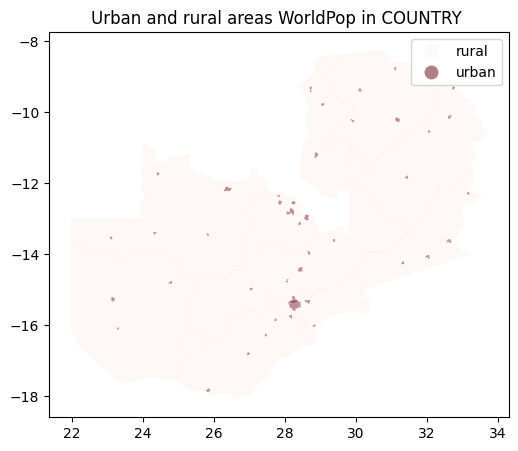

In [25]:
# map of the urban and rural areas WorldPop
# Create the axis first
fig2, ax2 = plt.subplots(figsize=(10, 5))
# Plot
grid.sort_values('locWorldPop', ascending=True).plot(
    ax=ax2, column='locWorldPop', cmap="Reds", legend=True, alpha=0.5)

ax2.set_aspect('equal', 'box')
txt = ax2.set_title('Urban and rural areas WorldPop in {} '.format(area))

Assess number of residential households per cell

In [29]:
# Load data into Pandas DataFrame
## Census data
data_path = "Residential/Data/"
census_name = 'Census_Zambia.csv'
df_censusdata = pd.read_csv(data_path + census_name)

resHHurban = {}
resHHrural = {}
for region in regions:
    data = df_censusdata[df_censusdata['Region']==region]
    resHHurban[region] = float(data['Urban'])
    resHHrural[region] = float(data['Rural'])
    print("Number of res HH in urban and rural areas in",f"{region}", resHHurban[region], resHHrural[region])
# df_censusdata

Number of res HH in urban and rural areas in Copperbelt 449077.0 85356.0
Number of res HH in urban and rural areas in Muchinga 24953.0 151730.0
Number of res HH in urban and rural areas in North-Western 91501.0 116233.0
Number of res HH in urban and rural areas in Western 54466.0 205604.0
Number of res HH in urban and rural areas in Luapula 44689.0 228300.0
Number of res HH in urban and rural areas in Northern 72867.0 230684.0
Number of res HH in urban and rural areas in Central 98493.0 292947.0
Number of res HH in urban and rural areas in Southern 120410.0 316294.0
Number of res HH in urban and rural areas in Eastern 82166.0 369725.0
Number of res HH in urban and rural areas in Lusaka 523768.0 108025.0


In [80]:
# Option 1: use buildings count from Worldpop
# total number of buildings
data_buildings = []
for region in regions:
    totalBuildings = grid[(grid['NAME_1'] == region)]['buildingssum'].sum()
    urbanBuildings = grid[(grid['location'] == "urban") & (grid['NAME_1'] == region)]['buildingssum'].sum()
    ruralBuildings = grid[(grid['location'] == "rural") & (grid['NAME_1'] == region)]['buildingssum'].sum()
    data_region = {
        'region': region,
        'totalBuildings': totalBuildings,
        'urbanBuildings': urbanBuildings,
        'ruralBuildings': ruralBuildings,
        'shareRuralBuild': ruralBuildings / totalBuildings,
        'shareUrbanBuild': urbanBuildings / totalBuildings
    }
    data_buildings.append(data_region)
    print("total Buildings in",f"{region}",f"{totalBuildings:,.0f}", "urban:",f"{urbanBuildings:,.0f}", "rural:",f"{ruralBuildings:,.0f}")
    print("share Build urban:", f"{data_region['shareUrbanBuild']:.0%}","rural:",f"{data_region['shareRuralBuild']:.0%}")

df_buildings = pd.DataFrame(data_buildings)
df_buildings = df_buildings.set_index('region')
df_buildings

total Buildings in Copperbelt 1,117,170 urban: 604,165 rural: 513,005
share Build urban: 54% rural: 46%
total Buildings in Muchinga 623,493 urban: 80,335 rural: 543,158
share Build urban: 13% rural: 87%
total Buildings in North-Western 576,163 urban: 151,021 rural: 425,142
share Build urban: 26% rural: 74%
total Buildings in Western 796,764 urban: 80,858 rural: 715,906
share Build urban: 10% rural: 90%
total Buildings in Luapula 615,968 urban: 84,579 rural: 531,389
share Build urban: 14% rural: 86%
total Buildings in Northern 823,956 urban: 104,365 rural: 719,591
share Build urban: 13% rural: 87%
total Buildings in Central 1,533,577 urban: 321,668 rural: 1,211,909
share Build urban: 21% rural: 79%
total Buildings in Southern 1,359,567 urban: 132,997 rural: 1,226,570
share Build urban: 10% rural: 90%
total Buildings in Eastern 1,359,153 urban: 119,052 rural: 1,240,101
share Build urban: 9% rural: 91%
total Buildings in Lusaka 1,156,294 urban: 747,954 rural: 408,340
share Build urban: 65

In [86]:
resUrbanBuildings = {}
resRuralBuildings = {}
resTotalBuildings = {}
shareUrbanResBuildings = {}
shareRuralResBuildings = {}
totalResHH = {}
totalResHHurban = {}
totalResHHrural = {}
nbOfHHperResBuilding_average = {}

# share of residential building in each location
# shareResBuildings = {"urban": 0.80, "rural": 0.5} # --> to change!
# shareResBuildings = {"urban": 0.5, "rural": 0.15} # --> to change! # number chosen to get 1 for nb of HH per rural building, and for urban twice the value in rural
# resUrbanBuildings = urbanBuildings*shareResBuildings["urban"]
# resRuralBuildings = ruralBuildings*shareResBuildings["rural"]
# resTotalBuildings = resUrbanBuildings + resRuralBuildings

# Assess the number of residential HH per building
nbOfHHperResBuilding =  {"urban": 1.2, "rural": 1}  # --> to change!
# nbOfHHperResBuilding["urban"]= resHHurban/resUrbanBuildings
# nbOfHHperResBuilding["rural"]= resHHrural/resRuralBuildings

# share of residential building in each location
for region in regions:
    shareUrbanResBuildings[region] = resHHurban[region]/(nbOfHHperResBuilding["urban"]* df_buildings.loc[region, 'urbanBuildings'])
    shareRuralResBuildings[region] = resHHrural[region]/(nbOfHHperResBuilding["rural"]* df_buildings.loc[region, 'ruralBuildings'])
    resUrbanBuildings[region] = df_buildings.loc[region, 'urbanBuildings'] * shareUrbanResBuildings[region]
    resRuralBuildings[region] = df_buildings.loc[region, 'ruralBuildings'] * shareRuralResBuildings[region]
    resTotalBuildings[region] = resUrbanBuildings[region] + resRuralBuildings[region]

    print("total Res Buildings in",f"{region}",f"{resTotalBuildings[region]:,.0f}", "urban:",f"{resUrbanBuildings[region]:,.0f}", "rural:",f"{resRuralBuildings[region]:,.0f}")
    print("share Res Build urban:", f"{shareUrbanResBuildings[region]:.0%}","rural:",f"{shareRuralResBuildings[region]:.0%}")
    print("nb Of HH per Res Building: urban", f"{nbOfHHperResBuilding['urban']:,.1f}","rural", f"{nbOfHHperResBuilding['rural']:,.1f}")
    
    # Assess the total number of HH in the region (should match the census data)
    totalResHHurban[region] = nbOfHHperResBuilding["urban"]*resUrbanBuildings[region]
    totalResHHrural[region] = nbOfHHperResBuilding["rural"]*resRuralBuildings[region]
    totalResHH[region] = totalResHHurban[region] + totalResHHrural[region]
    print("total Res HH: urban", f"{totalResHHurban[region]:,.0f}", "rural", f"{totalResHHrural[region]:,.0f}")
    nbOfHHperResBuilding_average[region] = totalResHH[region] / ((df_buildings.loc[region, 'urbanBuildings']*shareUrbanResBuildings[region]) +
                                                                 (df_buildings.loc[region, 'ruralBuildings'] * shareRuralResBuildings[region]))
    print("nb Of HH per Res Building average", f"{nbOfHHperResBuilding_average[region]:,.1f}")

# Compute the nb of HH per cell
grid['resBui'] = np.where( (grid['location'] == "urban"), grid[['buildingssum']].sum(axis=1), 0) * grid['NAME_1'].map(shareUrbanResBuildings) + np.where( (grid['location'] == "rural"), grid[['buildingssum']].sum(axis=1), 0) * grid['NAME_1'].map(shareRuralResBuildings)
grid["ResHH_urban"] = np.where( (grid['location'] == "urban"), grid[['buildingssum']].sum(axis=1), 0) * grid['NAME_1'].map(shareUrbanResBuildings) * nbOfHHperResBuilding["urban"]
grid["ResHH_rural"] = np.where( (grid['location'] == "rural"), grid[['buildingssum']].sum(axis=1), 0) * grid['NAME_1'].map(shareRuralResBuildings) * nbOfHHperResBuilding["rural"]

total Res Buildings in Copperbelt 459,587 urban: 374,231 rural: 85,356
share Res Build urban: 62% rural: 17%
nb Of HH per Res Building: urban 1.2 rural 1.0
total Res HH: urban 449,077 rural 85,356
nb Of HH per Res Building average 1.2
total Res Buildings in Muchinga 172,524 urban: 20,794 rural: 151,730
share Res Build urban: 26% rural: 28%
nb Of HH per Res Building: urban 1.2 rural 1.0
total Res HH: urban 24,953 rural 151,730
nb Of HH per Res Building average 1.0
total Res Buildings in North-Western 192,484 urban: 76,251 rural: 116,233
share Res Build urban: 50% rural: 27%
nb Of HH per Res Building: urban 1.2 rural 1.0
total Res HH: urban 91,501 rural 116,233
nb Of HH per Res Building average 1.1
total Res Buildings in Western 250,992 urban: 45,388 rural: 205,604
share Res Build urban: 56% rural: 29%
nb Of HH per Res Building: urban 1.2 rural 1.0
total Res HH: urban 54,466 rural 205,604
nb Of HH per Res Building average 1.0
total Res Buildings in Luapula 265,541 urban: 37,241 rural: 22

Assess number of residential households per cell with access to electricity

In [44]:
# for each hexagon, assessment of the number of HH
# access_elec = {"elec": 0, "nonelec": 1}
# sizeHH = {"urban": 4.7, "rural": 5.2} #https://population.un.org/Household/index.html#/countries/ https://dhsprogram.com/publications/publication-fr361-dhs-final-reports.cfm
#print(grid["Location"].map(shareResBuildings))
#grid["ResHHNbWithAccess"]=grid["buildingscount"]*grid["Location"].map(shareResBuildings)*grid["Status_electrified"].map(access_elec)

grid["ResHHNbWithAccessUrb"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "urban"), grid[['buildingssum']].sum(axis=1), 0) * grid['NAME_1'].map(shareUrbanResBuildings) * nbOfHHperResBuilding["urban"] * grid[columnProbElec]
                                        
grid["ResHHNbWithAccessRur"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "rural"), grid[['buildingssum']].sum(axis=1), 0) * grid['NAME_1'].map(shareRuralResBuildings) * nbOfHHperResBuilding["rural"] * grid[columnProbElec]

# grid["ResHHNbWithAccessUrb"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "urban"),
#                                                                             grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["urban"]*nbOfHHperResBuilding["urban"]                                        
# grid["ResHHNbWithAccessRur"] = np.where((grid['Status_electrified'] == "elec") & (grid['location'] == "rural"),
#                                                                             grid[['buildingssum']].sum(axis=1), 0)*shareResBuildings["rural"]*nbOfHHperResBuilding["rural"]

grid["ResHHNbWithAccess"] = grid[["ResHHNbWithAccessUrb", "ResHHNbWithAccessRur"]].sum(axis=1)

# totalResHHWithAccessUrb={}
totalResHHWithAccessUrb = grid.groupby('NAME_1')['ResHHNbWithAccessUrb'].sum()
totalResHHWithAccessRur = grid.groupby('NAME_1')['ResHHNbWithAccessRur'].sum()
totalResHHWithAccess = grid.groupby('NAME_1')['ResHHNbWithAccess'].sum()

for region in regions:
    print("totalResHHWithAccessUrb in",f"{region}",f"{totalResHHWithAccessUrb[region]:,.0f}")
    print("totalResHHWithAccessRur:",f"{totalResHHWithAccessRur[region]:,.0f}")
    print("totalResHHWithAccess:",f"{totalResHHWithAccess[region]:,.0f}")
# print(grid["ResHHNbWithAccessUrb"].sum() , grid["ResHHNbWithAccessRur"].sum(), grid["ResHHNbWithAccess"].sum())
grid.head(2)

totalResHHWithAccessUrb in Copperbelt 449,039
totalResHHWithAccessRur: 45,052
totalResHHWithAccess: 494,091
totalResHHWithAccessUrb in Muchinga 24,073
totalResHHWithAccessRur: 16,380
totalResHHWithAccess: 40,453
totalResHHWithAccessUrb in North-Western 85,636
totalResHHWithAccessRur: 21,627
totalResHHWithAccess: 107,263
totalResHHWithAccessUrb in Western 52,837
totalResHHWithAccessRur: 24,522
totalResHHWithAccess: 77,359
totalResHHWithAccessUrb in Luapula 42,539
totalResHHWithAccessRur: 67,695
totalResHHWithAccess: 110,234
totalResHHWithAccessUrb in Northern 69,697
totalResHHWithAccessRur: 33,319
totalResHHWithAccess: 103,016
totalResHHWithAccessUrb in Central 97,553
totalResHHWithAccessRur: 52,233
totalResHHWithAccess: 149,787
totalResHHWithAccessUrb in Southern 120,120
totalResHHWithAccessRur: 50,064
totalResHHWithAccess: 170,184
totalResHHWithAccessUrb in Eastern 79,686
totalResHHWithAccessRur: 38,701
totalResHHWithAccess: 118,388
totalResHHWithAccessUrb in Lusaka 522,715
totalResHH

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,...,locWorldPop,location,ResHH_urban,ResHH_rural,ResHHNbWithAccessUrb,ResHHNbWithAccessRur,ResHHNbWithAccess,ResEnergyCorrPerHH_raw,ResEnergyCorrPerHH,ResEnergy_kWh
0,8755a12a5ffffff,23.0269,-16.9721,9.0000,Western,1,37.0000,0.0000,0.0465,-0.4000,...,rural,rural,0.0000,10.6262,0.0000,0.0000,0.0000,73,73,0.0000
1,8739a3513ffffff,33.5028,-10.3349,5.0000,Muchinga,2,690.0000,0.0000,0.0431,-0.3008,...,rural,rural,0.0000,192.7500,0.0000,0.0000,0.0000,73,73,0.0000


Compute the resulting access rate

In [45]:
# access rate for HH
accessRateHH={}
accessRateHH_urban={}
accessRateHH_rural={}
for region in regions:
    accessRateHH[region] = totalResHHWithAccess[region]/totalResHH[region]
    accessRateHH_urban[region] = totalResHHWithAccessUrb[region]/totalResHHurban[region]
    accessRateHH_rural[region] = totalResHHWithAccessRur[region]/totalResHHrural[region]
    print("HH access rate in",f"{region}",f"{accessRateHH[region]:,.0%}")
    print("HH access rate urban:",f"{accessRateHH_urban[region]:,.0%}")
    print("HH access rate rural:",f"{accessRateHH_rural[region]:,.0%}")
# access rate for population
# accessRatePop = (totalResHHWithAccessUrb*pplperHH_urban+totalResHHWithAccessRur*pplperHH_rural)/totalPopStats
# accessRatePop_urban = totalResHHWithAccessUrb*pplperHH_urban/totalPop_urban
# accessRatePop_rural = totalResHHWithAccessRur*pplperHH_rural/totalPop_rural
# print("Pop access rate :",f"{accessRatePop:,.0%}")
# print("Pop access rate urban:",f"{accessRatePop_urban:,.0%}")
# print("Pop access rate rural:",f"{accessRatePop_rural:,.0%}")

HH access rate in Copperbelt 92%
HH access rate urban: 100%
HH access rate rural: 53%
HH access rate in Muchinga 23%
HH access rate urban: 96%
HH access rate rural: 11%
HH access rate in North-Western 52%
HH access rate urban: 94%
HH access rate rural: 19%
HH access rate in Western 30%
HH access rate urban: 97%
HH access rate rural: 12%
HH access rate in Luapula 40%
HH access rate urban: 95%
HH access rate rural: 30%
HH access rate in Northern 34%
HH access rate urban: 96%
HH access rate rural: 14%
HH access rate in Central 38%
HH access rate urban: 99%
HH access rate rural: 18%
HH access rate in Southern 39%
HH access rate urban: 100%
HH access rate rural: 16%
HH access rate in Eastern 26%
HH access rate urban: 97%
HH access rate rural: 10%
HH access rate in Lusaka 90%
HH access rate urban: 100%
HH access rate rural: 42%


Compute the energy consumption assessment per cell

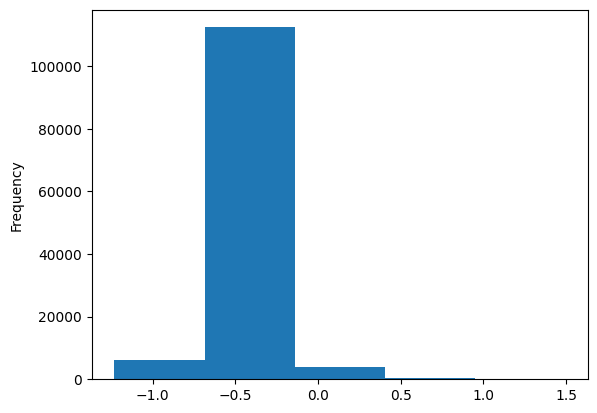

[(-1.2319999933242798, 5), (-0.6863499879837036, 73), (-0.14069998264312744, 365), (0.40495002269744873, 1250), (0.9506000280380249, 3012)]


In [46]:
# rwi to energy consumption
def rwi_to_energy(rwi):
    energy = 0
    for key, val in table_encons:
        if rwi < key:
            break
        else: energy = val
    return energy

grid['rwi'].plot.hist(bins=5)
plt.show()
file_HHenergycons = "HH_energyconsumption.csv"
HHenergycons = pd.read_csv(data_path + file_HHenergycons)
# print(HHenergycons)
thresholds_rwi = (grid['rwi'].max()-grid['rwi'].min())/5*np.arange(5)+grid['rwi'].min()
thresholds_energy = HHenergycons.iloc[0].tolist() # thresholds_energy  = [5, 73, 365, 1250, 3012]
table_encons = list(zip(thresholds_rwi, thresholds_energy))
print(table_encons)
grid['ResEnergyCorrPerHH_raw'] = grid['rwi'].apply(rwi_to_energy)

In [47]:
# Energy Consumption assessment per cell
averageRwi = grid['rwi'].mean()
# grid["ResEnergyCorrPerHH"] = abs(grid['rwi']/averageRwi)*grid["ADM1_NAME"].map(energyConsHH)
grid["ResEnergyCorrPerHH"] = grid['ResEnergyCorrPerHH_raw']*abs(grid['rwi']/averageRwi)
grid["ResEnergyCorrPerHH"] = grid['ResEnergyCorrPerHH_raw']
grid["ResEnergy_kWh"] = grid["ResHHNbWithAccess"] * grid["ResEnergyCorrPerHH"]

In [48]:
total_residentialenergy_assessed = grid["ResEnergy_kWh"].sum()
print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh
total_residentialenergy_assessed = total_residentialenergy_assessed/10**6  # conversion in GWh

residential electricity consumption: 2,819 GWh


# Scale residential demand results

Get the electricity consumption at the national level for HH

In [91]:
energyBalance_path = "EnergyBalance/"
file_energyBalance = "UNSD+DF_UNData_EnergyBalance+1.0_Zambia.csv"
eb = pd.read_csv(energyBalance_path + file_energyBalance)
code_elec = "B07_EL"
code_hh =  "B50_1231"
total_residentialenergy = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_hh) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
total_residentialenergy = pd.to_numeric(total_residentialenergy.str.replace(',', '')) # convert to numeric and remove commas
total_residentialenergy = total_residentialenergy.iloc[0]/3.6 # conversion in GWh
print("residential electricity consumption UN STATS:", f"{total_residentialenergy:,.0f}", "GWh")
print("residential electricity consumption assessed:", f"{total_residentialenergy_assessed:,.0f}", "GWh")

residential electricity consumption UN STATS: 4,022 GWh
residential electricity consumption assessed: 2,819 GWh


Compute total electricity consumption

In [52]:
total_residentialenergy_beforescaled = grid.groupby('NAME_1')['ResEnergy_kWh'].sum() 
for region in regions:
    total_residentialenergy_beforescaled[region] = total_residentialenergy_beforescaled[region]/10**6  # conversion in GWh
    print ("Residential electricity consumption assessed before scaling:",region, f"{total_residentialenergy_beforescaled[region]:,.1f}", "GWh" )

Residential electricity consumption assessed before scaling: Copperbelt 942.9 GWh
Residential electricity consumption assessed before scaling: Muchinga 11.4 GWh
Residential electricity consumption assessed before scaling: North-Western 102.7 GWh
Residential electricity consumption assessed before scaling: Western 33.9 GWh
Residential electricity consumption assessed before scaling: Luapula 23.5 GWh
Residential electricity consumption assessed before scaling: Northern 60.2 GWh
Residential electricity consumption assessed before scaling: Central 167.5 GWh
Residential electricity consumption assessed before scaling: Southern 166.8 GWh
Residential electricity consumption assessed before scaling: Eastern 54.0 GWh
Residential electricity consumption assessed before scaling: Lusaka 1,255.7 GWh


In [53]:
# Scale previous results if area is country
scaling_factor = total_residentialenergy/total_residentialenergy_assessed
if area == "COUNTRY":
    print('{:.0%}'.format(scaling_factor))
    grid["REnS_kWh"] = grid["ResEnergy_kWh"] * scaling_factor
else:
    grid["REnS_kWh"] = grid["ResEnergy_kWh"]

143%


In [54]:
total_residentialenergy_scaled = grid.groupby('NAME_1')['REnS_kWh'].sum()    
for region in regions:
    total_residentialenergy_scaled[region] = total_residentialenergy_scaled[region]/10**6  # conversion in GWh
    print ("Residential electricity consumption assessed:",region, f"{total_residentialenergy_scaled[region]:,.1f}", "GWh" )

Residential electricity consumption assessed: Copperbelt 1,345.7 GWh
Residential electricity consumption assessed: Muchinga 16.3 GWh
Residential electricity consumption assessed: North-Western 146.5 GWh
Residential electricity consumption assessed: Western 48.3 GWh
Residential electricity consumption assessed: Luapula 33.5 GWh
Residential electricity consumption assessed: Northern 85.9 GWh
Residential electricity consumption assessed: Central 239.0 GWh
Residential electricity consumption assessed: Southern 238.1 GWh
Residential electricity consumption assessed: Eastern 77.1 GWh
Residential electricity consumption assessed: Lusaka 1,792.0 GWh


In [55]:
grid.to_csv("data.csv")
grid.to_file(out_path + "\\" + 'res_energy_map.shp', index=False)
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,...,location,ResHH_urban,ResHH_rural,ResHHNbWithAccessUrb,ResHHNbWithAccessRur,ResHHNbWithAccess,ResEnergyCorrPerHH_raw,ResEnergyCorrPerHH,ResEnergy_kWh,REnS_kWh
0,8755a12a5ffffff,23.0269,-16.9721,9.0000,Western,1,37.0000,0.0000,0.0465,-0.4000,...,rural,0.0000,10.6262,0.0000,0.0000,0.0000,73,73,0.0000,0.0000
1,8739a3513ffffff,33.5028,-10.3349,5.0000,Muchinga,2,690.0000,0.0000,0.0431,-0.3008,...,rural,0.0000,192.7500,0.0000,0.0000,0.0000,73,73,0.0000,0.0000
2,87344eadbffffff,27.2583,-16.9584,8.0000,Southern,3,309.0000,0.0000,0.1061,-0.2715,...,rural,0.0000,79.6814,0.0000,0.0000,0.0000,73,73,0.0000,0.0000


# Services

Get the electricity consumption for services

In [90]:
# energyBalance_path = "EnergyBalance/"
# file_energyBalance = "UNSD+DF_UNData_EnergyBalance+1.0_Zambia.csv"
# eb = pd.read_csv(energyBalance_path + file_energyBalance)
# code_elec = "B07_EL"
code_ser =  "B49_1235"
cod_oth = "B51_1234" # Other consumption not elsewhere specified in UN stats
total_servicesenergy = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_ser) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
total_servicesenergy = pd.to_numeric(total_servicesenergy.str.replace(',', '')) # convert to numeric and remove commas
total_servicesenergy = total_servicesenergy.iloc[0]/3.6 # conversion in GWh
print("services electricity consumption UN STATS:", f"{total_servicesenergy:,.0f}", "GWh")

services electricity consumption UN STATS: 722 GWh


In [92]:
# services building in each location
grid['serBui'] = grid['buildingssum'] - grid['resBui']
totalSerBui = grid['serBui'].sum()
totalSerBui

6555215.333333335

In [101]:
# energy consumption per building in services
grid['serBUi_Acc'] = grid['serBui'] * grid[columnProbElec]
totalSerBui_withAccess = grid['serBUi_Acc'].sum()
print("total services buildings with access:", f"{totalSerBui_withAccess:,.0f}")
ser_enBui = total_servicesenergy / totalSerBui_withAccess 
ser_enBui = ser_enBui *10**6 #conversion in kWh
print(f"{ser_enBui:,.0f}", "kWh per building")

total services buildings with access: 2,515,779
287 kWh per building


In [104]:
# compute services energy demand
grid['SEn_kWh'] = ser_enBui * grid['serBUi_Acc']

In [103]:
grid.to_csv("dataser.csv")
grid.to_file(out_path + "\\" + 'ser_energy_map.shp', index=False)
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,...,ResHHNbWithAccessRur,ResHHNbWithAccess,ResEnergyCorrPerHH_raw,ResEnergyCorrPerHH,ResEnergy_kWh,REnS_kWh,resBui,serBui,serBUi_Acc,serEnergy_kWh
0,8755a12a5ffffff,23.026863,-16.972095,9.0,Western,1,37.0,0.0,0.046453,-0.40000,...,0.0,0.0,73,73,0.0,0.0,10.626183,26.373817,1.225130,351.436057
1,8739a3513ffffff,33.502829,-10.334898,5.0,Muchinga,2,690.0,0.0,0.043113,-0.30075,...,0.0,0.0,73,73,0.0,0.0,192.749992,497.250008,21.437873,6149.585142
2,87344eadbffffff,27.258341,-16.958375,8.0,Southern,3,309.0,0.0,0.106106,-0.27150,...,0.0,0.0,73,73,0.0,0.0,79.681425,229.318575,24.332184,6979.836175
